External Regressors
Next, we will include external regressors to try to improve the predictions.

1.- (4 points) Include as external regressors monthly average PriceStats inflation rate data and monthly BER data. Use cross-correlation plots to find the lag between the following:
CPI inflation rate and PriceStats inflation rate
CPI and BER inflation rate.
Import statsmodels.tsa.stattools

In [15]:
import pandas as pd
import numpy as np
dfPSt=pd.read_csv('PriceStats_CPI.csv',keep_default_na=True)
dfPSt=dfPSt.dropna(axis=0)
dfBER=pd.read_csv('T10YIE.csv',keep_default_na=True)
dfBER=dfBER.dropna(axis=0)

dfPSt['date']=pd.to_datetime(dfPSt['date'])
dfBER['DATE']=pd.to_datetime(dfBER['DATE'])

dfPSt['year'] = pd.DatetimeIndex(dfPSt['date']).year
dfPSt['month'] = pd.DatetimeIndex(dfPSt['date']).month
dfPSt['day'] = pd.DatetimeIndex(dfPSt['date']).day

dfBER['year'] = pd.DatetimeIndex(dfBER['DATE']).year
dfBER['month'] = pd.DatetimeIndex(dfBER['DATE']).month
dfBER['day'] = pd.DatetimeIndex(dfBER['DATE']).day

dfPSt['ndate']=dfPSt['year']*100+dfPSt['month']
dfBER['nDATE']=dfBER['year']*100+dfBER['month']

df1=dfPSt.groupby(['year', 'month']).agg( { 'date':'first', 'ndate':'first', 'CPI': 'first', 'PriceStats': 'mean' }).reset_index()
df2=dfBER.groupby(['year', 'month']).agg( {'DATE':'first', 'nDATE':'first','T10YIE': 'mean'  }).reset_index()

CPIt_1=df1.iloc[0]['CPI']
PStt_1=df1.iloc[0]['PriceStats']
_IR=[]
_IP=[]
for i in range(len(df1)):
  CPIt=df1.iloc[i]['CPI']
  PStt=df1.iloc[i]['PriceStats']
  IRt=((CPIt-CPIt_1)/CPIt_1)*100
  IPt=((PStt-PStt_1)/PStt_1)*100
  _IR.append(IRt)
  _IP.append(IPt)
  CPIt_1=CPIt
  PStt_1=PStt
df1['IRC']=_IR
df1['IPS']=_IP

df = pd.merge(df1, df2, left_on='ndate',right_on='nDATE',how='inner')
df=df.reset_index()
df=df.drop(['year_x','year_y','month_x','month_y','DATE','ndate','nDATE'],axis=1)
df['BERm']=((df['T10YIE']+1)**(1/12))-1
df

#compute CPIt-CPIt-1/CPIt-1 , PStt-PStt-1/PStt-1  BERmt=(BERyt - 1)(1/12)+1

,index,date,CPI,PriceStats,IRC,IPS,T10YIE,BERm
0,0,2008-07-24,100.00000,99.921038,0.000000,0.000000,2.438636,0.108406
1,1,2008-08-01,100.52510,99.727196,0.525100,-0.193995,2.209524,0.102055
2,2,2008-09-01,100.12380,99.770512,-0.399204,0.043435,1.836190,0.090757
3,3,2008-10-01,99.98538,99.011287,-0.138249,-0.760972,1.061818,0.062154
4,4,2008-11-01,98.97539,97.221704,-1.010138,-1.807454,0.638333,0.041998
...,...,...,...,...,...,...,...,...
131,131,2019-06-01,117.03590,117.803490,0.212866,-0.046040,1.700000,0.086293
132,132,2019-07-01,117.05920,117.906677,0.019908,0.087593,1.752727,0.088045
133,133,2019-08-01,117.25480,117.894145,0.167095,-0.010629,1.586364,0.082408
134,134,2019-09-01,117.24880,118.010377,-0.005117,0.098590,1.587000,0.082430


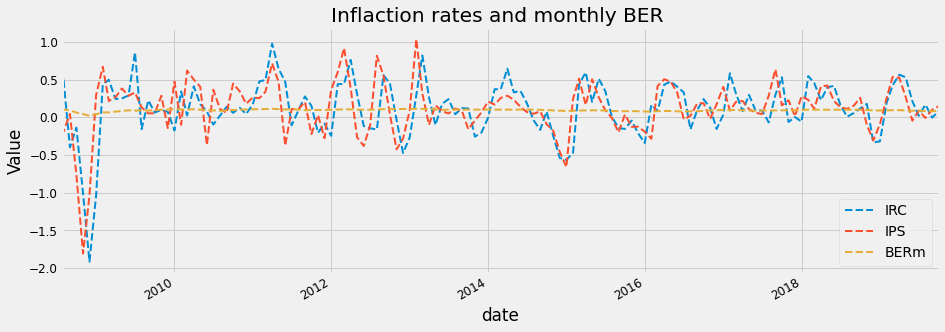

In [17]:
ddl = df.drop(['index','CPI','PriceStats','T10YIE'], axis=1)
ddl=ddl.set_index('date')
plt.style.use('fivethirtyeight')
ax=ddl.plot(figsize=(14,5),fontsize = 12,linewidth = 2,linestyle='--')#(color='blue')
ax.set_xlabel('date')
ax.set_ylabel('Value')
ax.set_title('Inflaction rates and monthly BER ')
plt.show()

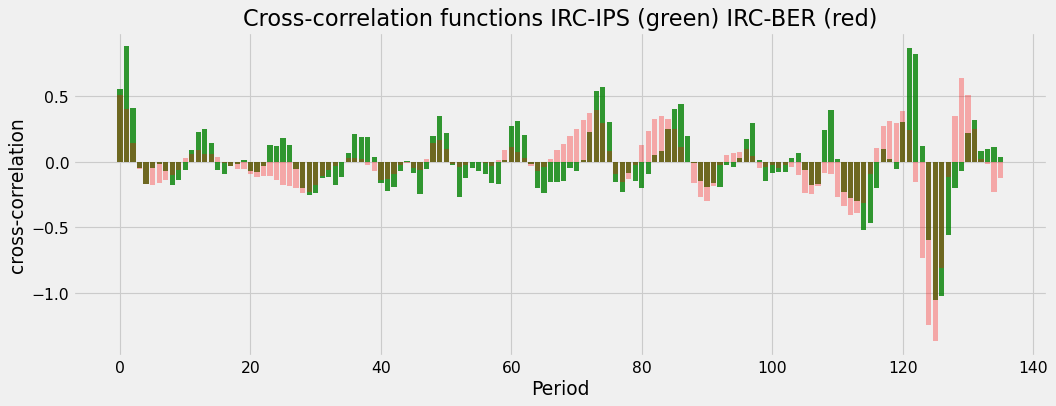

Max values indices for IRC-IPS: [125 126   1 121 122 124  74   0 127  73]
Max values indices for IRC-BER: [125 124 126 123 129 130   0 112   1  73]


In [18]:
import statsmodels.tsa.stattools as st
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
ccfp=st.ccf(df['IRC'], df['IPS'])
xp=np.arange(ccfp.shape[0])
ccfb=st.ccf(df['IRC'], df['BERm'])
xb=np.arange(ccfb.shape[0])

figure(figsize=(14, 5), dpi=80)
plt.xlabel('Period')
plt.ylabel('cross-correlation')
plt.title('Cross-correlation functions IRC-IPS (green) IRC-BER (red)')
plt.bar(xp,ccfp,color='green',alpha = 0.8)
plt.bar(xb,ccfb,alpha=0.3,color='red')
plt.show()
print ('Max values indices for IRC-IPS:',np.argsort(-abs(ccfp))[:10])
print ('Max values indices for IRC-BER:',np.argsort(-abs(ccfb))[:10])

<Figure size 1120x400 with 0 Axes>

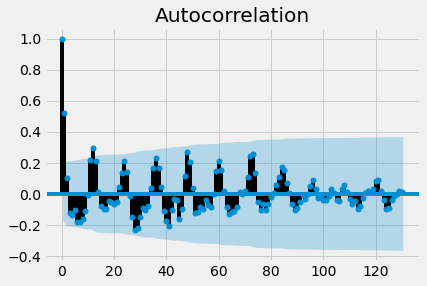

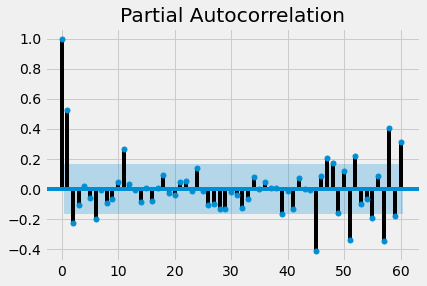

In [24]:
#There is not trend and not obvious periodic seasonal pattern
#so we will plot the ACF to see if there is a trend
figure(figsize=(14, 5), dpi=80)
sm.graphics.tsa.plot_acf(df['IRC'].values.squeeze(), lags=130)
plt.show()
sm.graphics.tsa.plot_pacf(df['IRC'].values.squeeze(), lags=60)
plt.show()

2.- (3 points) Fit a new AR model to the CPI inflation rate with these external regressors and the most appropriate lag. Report the coefficients. Python Tip: You may use use sm.tsa.statespace.SARIMAX.

In [31]:
df_train=df.loc[df['date'] <'2013-09-01']
df_test=df.loc[df['date'] >='2013-09-01']
df_train.shape,df_test.shape

((62, 8), (74, 8))

In [78]:
import statsmodels.api as sm
# Fit the model
(p,d,q)=(1,0,0)
(P,D,Q,s)=(0,0,0,6)
mod = sm.tsa.statespace.SARIMAX(endog=df_train['IRC'],exog=df_train[['IPS','BERm']], trend='n', order=(p,d,q),seasonal_order=(P,D,Q,s))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    IRC   No. Observations:                   62
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 -25.452
Date:                Sun, 09 May 2021   AIC                             58.903
Time:                        16:56:01   BIC                             67.412
Sample:                             0   HQIC                            62.244
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IPS            0.3460      0.118      2.926      0.003       0.114       0.578
BERm           1.0844      0.847      1.280      0.201      -0.576       2.745
ar.L1          0.2870      0.098      2.917      0.0

3.- (3 points) Report the mean squared prediction error for 1 month ahead forecasts.

p= 1  Test RMSE:  0.1991064428624406


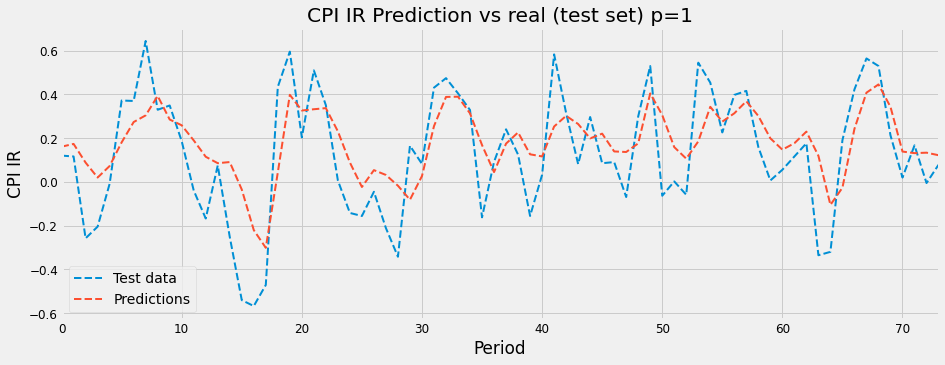

In [79]:
    from sklearn.metrics import mean_squared_error
    #res=AutoReg(dfi_train,p,trend='n').fit()
    #print (res.summary())

    #compute RMSE
    
    nexreg=2
    
    xRt=df_train.values
    xRtt=df_test.values

    #res=AutoReg(xRt,p,trend='n').fit()
    #model = AR(train)
    #model_fit = model.fit()
    window = p #model_fit.k_ar
    coef = res.params #model_fit.params
    # walk forward over time steps in test
    history = xRt[len(xRt)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(xRtt)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]*lag[0][5]+coef[1]*lag[0][7]
        for d in range(window):
            yhat += coef[d+nexreg] * lag[window-d-1][4]
        obs = xRtt[t]
        predictions.append(yhat)
        history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    rmse = np.sqrt(mean_squared_error(xRtt[:,4], predictions))
    print('p=',p,' Test RMSE: ',rmse)
    #_RMSE.append(rmse)
    
    s1 = pd.Series(xRtt[:,4].ravel())
    s2 = pd.Series(predictions)

    frame = { 'Test data': s1 ,'Predictions':s2}
    dpr3 = pd.DataFrame(frame)

    plt.style.use('fivethirtyeight')
    ax=dpr3.plot(figsize=(14,5),fontsize = 12,linewidth = 2,linestyle='--')#(color='blue')
    ax.set_xlabel('Period')
    ax.set_ylabel('CPI IR')
    ax.set_title('CPI IR Prediction vs real (test set) p='+str(p))
    plt.show()
